In [8]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load the dataset
data_1 = pd.ExcelFile('corelogic_data.xlsx')
data_2 = pd.ExcelFile('abs_housing_summary.xlsx')

# print sheet names for excels
print("Sheets in corelogic_data.xlsx:", data_1.sheet_names)
print("Sheets in abs_housing_summary.xlsx:", data_2.sheet_names)

Sheets in corelogic_data.xlsx: ['Index Values', 'About Us', 'Copyright and Disclaimer Notice']
Sheets in abs_housing_summary.xlsx: ['Contents', 'Table 1', 'Table 2', 'Table 3', 'Table 4', 'Table 5', 'Table 6', 'Table 7', 'Table 8']


In [69]:
# let's begin by working on corelogic data --- only "Index Values" has the data
df = data_1.parse('Index Values')

# row 2 is the header, so we set it. Then skip the first two rows
df.columns = df.iloc[2]

df = df[3:] 

df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
    .str.replace(r"\(.*\)", "", regex=True)
    .str.replace("__+", "_", regex=True)
    .str.replace("[^a-z0-9_]", "", regex=True)
    .str.rstrip("_")
)
for col in df.columns:
    if col != 'date':
        df[col] = pd.to_numeric(df[col], errors='coerce')
df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')
df = df.rename(columns={"5_capital_city_aggregate": "5_capitals"})

In [70]:
df.head()
#df.info()

2,date,sydney,melbourne,brisbane,adelaide,perth,5_capitals
3,2025-06-12,237.88,180.79,199.84,210.31,173.78,207.43
4,2025-06-11,237.83,180.77,199.76,210.23,173.77,207.39
5,2025-06-10,237.66,180.71,199.70,210.16,173.77,207.29
6,2025-06-09,237.60,180.64,199.75,210.08,173.71,207.24
7,2025-06-08,237.57,180.61,199.73,210.00,173.75,207.23


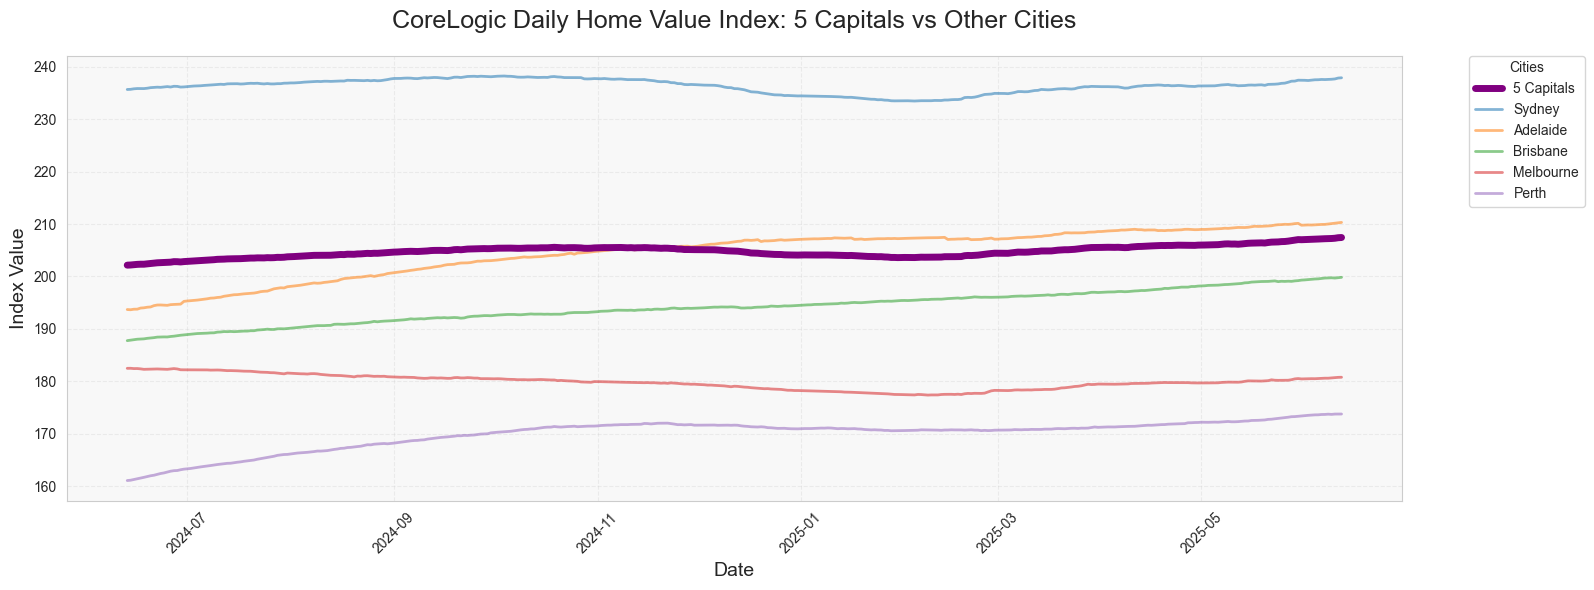

In [96]:
highlight = '5_capitals'
city_columns = [col for col in df.columns if col not in ['date', highlight]]
plt.figure(figsize=(16, 6))
sns.set_style("whitegrid")
ax = plt.gca()
ax.set_facecolor('#f8f8f8')
plt.grid(True, alpha=0.3, linestyle='--')
colors = sns.color_palette("tab10", n_colors=len(city_columns))

# Get final values for sorting
final_values = {}
for city in city_columns:
    final_values[city] = df[city].iloc[-1]

# Sort cities by their final values (descending)
sorted_cities = sorted(city_columns, key=lambda x: final_values[x], reverse=True)

# Faded city lines
for i, city in enumerate(sorted_cities):
    label = city.replace('_', ' ').title()
    plt.plot(df['date'], df[city],
             label=label, linewidth=2, alpha=0.55, color=colors[i], zorder=2)

# Bold aggregate line (black for visibility)
agg_label = '5 Capitals'
plt.plot(df['date'], df[highlight],
         label=agg_label, linewidth=5, alpha=1, color='purple', zorder=10)

ax = plt.gca()
ax.set_facecolor('#f8f8f8')
plt.title("CoreLogic Daily Home Value Index: 5 Capitals vs Other Cities", fontsize=18, pad=20)
plt.ylabel("Index Value", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
# Reorder legend to put aggregate first
handles, labels = plt.gca().get_legend_handles_labels()
agg_idx = labels.index(agg_label)
handles = [handles[agg_idx]] + handles[:agg_idx] + handles[agg_idx+1:]
labels = [labels[agg_idx]] + labels[:agg_idx] + labels[agg_idx+1:]
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', 
           borderaxespad=0, frameon=True, fontsize=10, title="Cities")
plt.tight_layout()
plt.show()


## Key Takeaways: Housing Value Index Trends

- The 5 capital cities' aggregate index shows a distinct trend compared to individual cities, highlighting the collective market behavior.
- There is significant variation in property value growth across different Australian cities, with some outperforming the capital aggregate.
- The visualization reveals periods of synchronization and divergence in housing markets across Australia.

### Questions to Consider:

- What economic or policy factors might explain the divergence between certain cities and the 5 capitals aggregate?
- How might these trends impact housing affordability in different regions of Australia?

In [130]:
df = data_2.parse('Table 1')

df = df.iloc[8:].reset_index(drop=True)

# get the name of the header columns 
header_rows = df.iloc[0:3].fillna('').astype(str)
new_columns = (
    header_rows.iloc[0] + ' ' + header_rows.iloc[1] + ' ' + header_rows.iloc[2]
).str.replace(' +', ' ', regex=True).str.strip()
df.columns = new_columns
df = df.iloc[3:].reset_index(drop=True)
df = df.iloc[0:3].reset_index(drop=True)
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
    .str.replace(r"\(.*\)", "", regex=True)
    .str.replace("__+", "_", regex=True)
    .str.replace("[^a-z0-9_]", "", regex=True)
    .str.rstrip("_")
)
df = df.rename(columns={df.columns[0]: "dwelling_type"})

cols_to_numeric = [
    col for col in df.columns 
    if col not in ['dwelling_type', 'index', ''] 
    and not col.lower().startswith('unnamed')
]

for col in cols_to_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [131]:
df.head()
#df.info()

,dwelling_type,new_south_wales,victoria,queensland,south_australia,western_australia,tasmania,northern_territory,capital_territory,total
0,Occupied private dwellings,3058269,2507636,1998032,723158,1029762,229427,85374,174972,9808428
1,Unoccupied private dwellings,299524,298029,192393,83821,118109,29185,10404,11988,1043776
2,Non-private dwellings,6984,5110,5085,1387,2386,690,715,187,22616


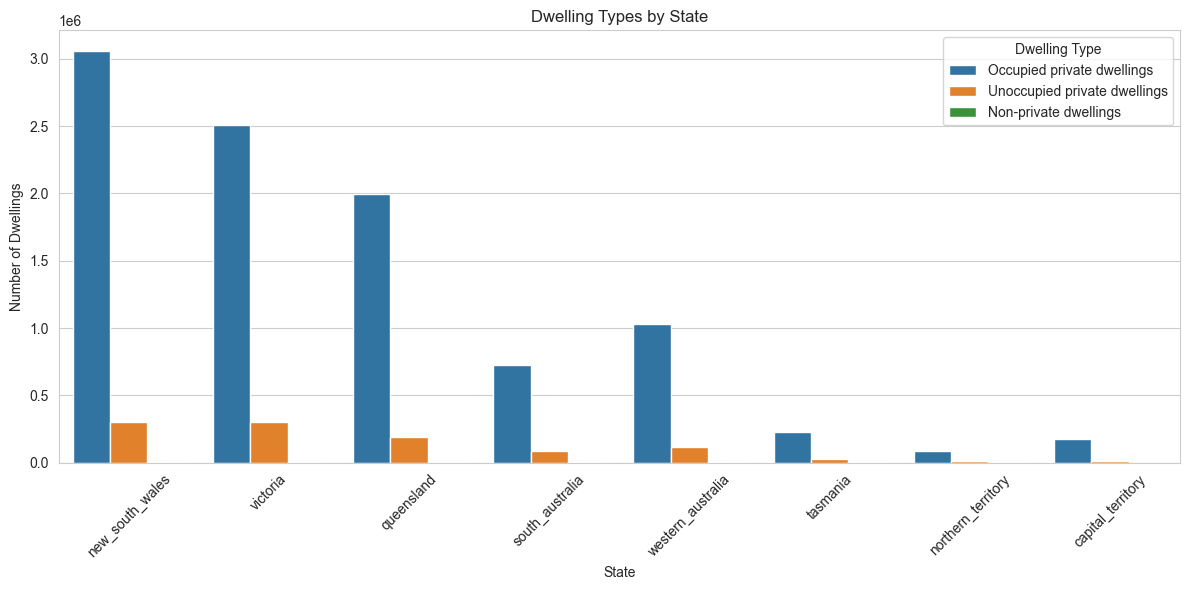

In [ ]:
df = df.drop(columns=['total'])

df_long = df.melt(
    id_vars='dwelling_type', 
    var_name='state', 
    value_name='count'
)

df_long['count'] = pd.to_numeric(df_long['count'], errors='coerce')

plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_long,
    x='state',
    y='count',
    hue='dwelling_type'
)
plt.title('Dwelling Types by State')
plt.xlabel('State')
plt.ylabel('Number of Dwellings')
plt.xticks(rotation=45)
plt.legend(title='Dwelling Type')
plt.tight_layout()
plt.show()


# print table values


## Key Takeaways: Dwelling Types Across States

- There is significant variation in the distribution of dwelling types across Australian states and territories.
- Houses dominate the residential landscape in most states, but there are notable differences in the proportion of apartments and semi-detached dwellings.
- The distribution reveals regional housing preferences and development patterns across Australia.

### Questions to Consider:

- How might changing demographics and housing preferences shift these proportions in the coming decades?

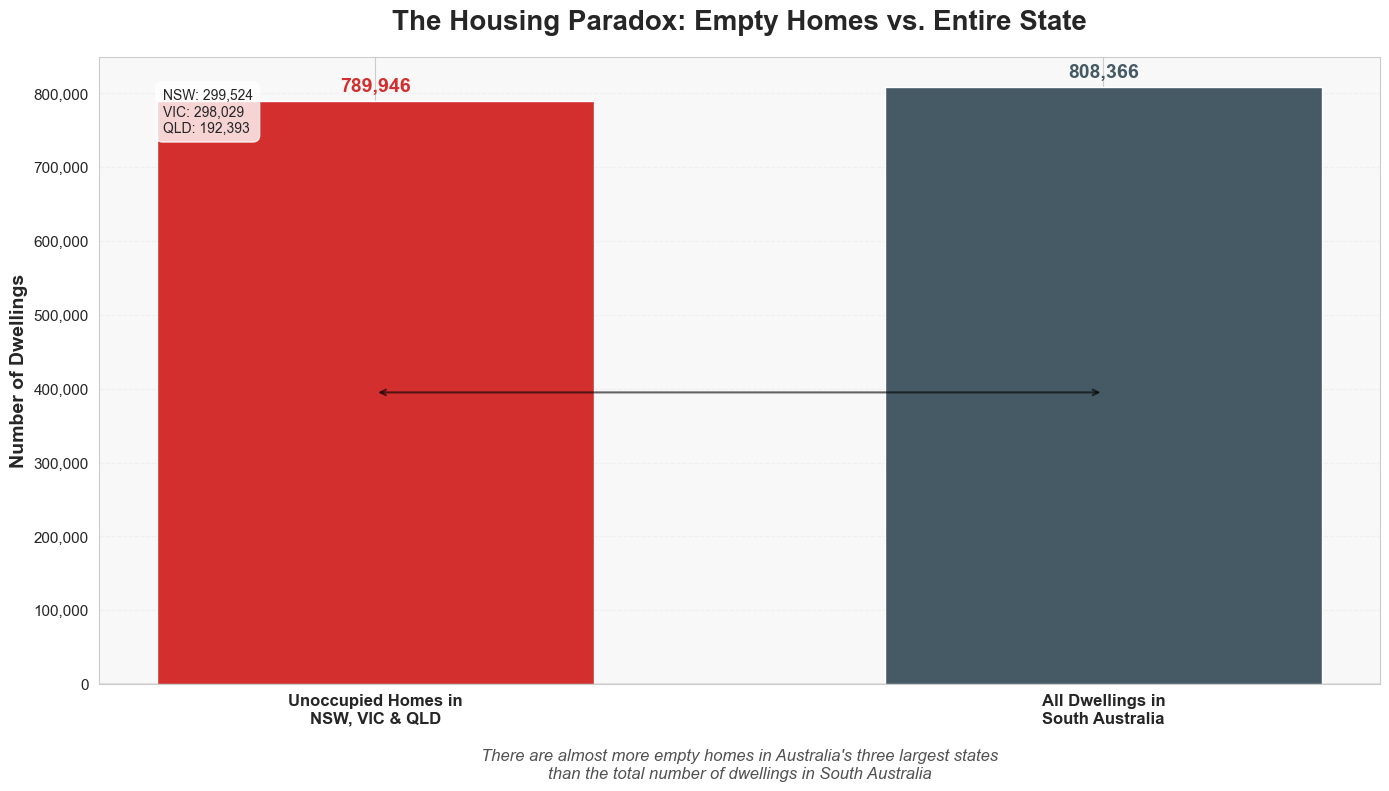

,new_south_wales,victoria,queensland,south_australia,western_australia,tasmania,northern_territory,capital_territory
dwelling_type,,,,,,,,
Occupied private dwellings,3058269,2507636,1998032,723158,1029762,229427,85374,174972
Unoccupied private dwellings,299524,298029,192393,83821,118109,29185,10404,11988
Non-private dwellings,6984,5110,5085,1387,2386,690,715,187


,new_south_wales,victoria,queensland,south_australia,western_australia,tasmania,northern_territory,capital_territory
dwelling_type,,,,,,,,
Occupied private dwellings,90.9,89.2,91.0,89.5,89.5,88.5,88.5,93.5
Unoccupied private dwellings,8.9,10.6,8.8,10.4,10.3,11.3,10.8,6.4
Non-private dwellings,0.2,0.2,0.2,0.2,0.2,0.3,0.7,0.1


In [ ]:
unocc = df[df['dwelling_type'] == 'Unoccupied private dwellings']

main_states = ['new_south_wales', 'victoria', 'queensland']
unocc_main = unocc[main_states].astype(float).sum(axis=1).values[0]

sa_total = df['south_australia'].astype(float).sum()

groups = ['Unoccupied Homes in\nNSW, VIC & QLD', 'All Dwellings in\nSouth Australia']
values = [unocc_main, sa_total]

# Create a more impactful figure
plt.figure(figsize=(14, 8))
ax = plt.gca()
ax.set_facecolor('#f8f8f8')

# Use a more striking color contrast
bars = plt.bar(groups, values, color=['#d32f2f', '#455a64'], width=0.6)

# Add a horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='-', alpha=0.1, linewidth=2)

# Add labels with more presence
plt.ylabel('Number of Dwellings', fontsize=14, fontweight='bold')
plt.title('The Housing Paradox: Empty Homes vs. Entire State', 
          fontsize=20, fontweight='bold', pad=20)

# Add data labels with better styling
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height*1.01,
             f"{int(values[i]):,}",
             ha='center', va='bottom',
             fontsize=14, fontweight='bold',
             color=bars[i].get_facecolor())

# Add a subtitle/explanation
plt.text(0.5, -0.15, 
         "There are almost more empty homes in Australia's three largest states\nthan the total number of dwellings in South Australia",
         transform=ax.transAxes, ha='center', fontsize=12, 
         style='italic', alpha=0.8)

# Add visual emphasis to show proportion
plt.annotate("", xy=(0, values[0]*0.5), xytext=(1, values[0]*0.5), 
             arrowprops=dict(arrowstyle="<->", color='black', lw=1.5, alpha=0.6))

# Style the grid and tick marks
plt.grid(axis='y', linestyle='--', alpha=0.2)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=11)

# Format y-axis with commas for thousands
from matplotlib.ticker import FuncFormatter
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x):,}'))

# Add individual state breakdowns as a text box
state_values = {}
for state in main_states:
    state_values[state] = unocc[state].iloc[0]
    
breakdown = "\n".join([
    f"NSW: {int(state_values['new_south_wales']):,}",
    f"VIC: {int(state_values['victoria']):,}",
    f"QLD: {int(state_values['queensland']):,}"
])

props = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8)
plt.text(0.05, 0.95, breakdown, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

pivot_df = df.set_index('dwelling_type')

percent_df = (pivot_df / pivot_df.sum(axis=0)) * 100
percent_df = percent_df.round(1)

display(pivot_df)
display(percent_df)

## Key Takeaways: The Housing Paradox

- The number of unoccupied private dwellings in Australia's three largest states (NSW, VIC, QLD) nearly equals the total housing stock of South Australia.
- This paradox highlights potential inefficiencies in housing allocation across the country.
- The state-by-state breakdown reveals significant variations in vacant property numbers.

### Questions to Consider:

- What factors contribute to such high numbers of unoccupied dwellings in major states?
- What economic and social implications arise from having so many vacant properties while housing demand remains high?

### The Mismatch Between Housing Distribution and Need
Australia's housing landscape reveals a striking paradox: while housing prices continue to climb in major cities and affordability remains a critical issue, our analysis shows hundreds of thousands of homes sitting vacant. This fundamental mismatch suggests that the housing crisis may be less about absolute supply and more about distribution, speculation, and policy choices. The fact that the number of unoccupied dwellings in NSW, VIC, and QLD rivals the entire housing stock of South Australia raises profound questions about how effectively our housing market allocates resources in relation to actual need.

### Regional Divergence Signals Shifting Economic Patterns
The diverging performance of different Australian cities in the housing index suggests we're witnessing more than just a national trend. While the five capitals aggregate shows one pattern, individual cities are increasingly charting their own courses, likely reflecting changing migration patterns, employment opportunities, and lifestyle preferences post-COVID. This regional divergence may be an early indicator of broader economic shifts, with implications for everything from infrastructure planning to interest rate policies. As cities grow more distinct in their housing market behaviors, national policy approaches may become increasingly inadequate for addressing regional-specific challenges.

